In [278]:
# extracting PSFs --> sourcing from 12a
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import skew
import getpass

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')


In [279]:
!pip install opencv-python

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [281]:
def getPsfProperties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
    fwhm : `float`
        Full-width at half maximum: PSF determinant radius
        from SDSS adaptive moments matrix (sigma) times
        SIGMA_TO_FWHM.
    ap_flux : `float`
        PSF flux from aperture photometry weighted
        by a sinc function.
    peak : `float`
        Peak PSF value.
    dims : `lsst.geom.ExtendI`
        PSF postage stamp dimensions.
    """
    SIGMA_TO_FWHM = 2.0*np.sqrt(2.0*np.log(2.0))
    sigma = psf.computeShape(point).getDeterminantRadius()
    fwhm = sigma * SIGMA_TO_FWHM
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    dims = psf.computeImage(point).getDimensions()
    # help(dims)
    # help(psf.computeImage)

    print(f"PSF FWHM: {fwhm:.4} pix \n"
          f"PSF flux from aperture photometry: {ap_flux:.4} \n"
          f"Peak PSF value: {peak:.4} \n"
          f"PSF postage stamp dimensions: {dims} \n")

    return (sigma, ap_flux, peak, dims)


FITS standard SkyWcs:
Sky Origin: (52.9411764706, -33.4710743802)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


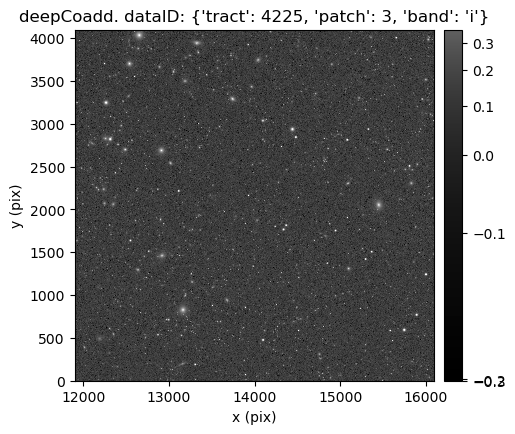

In [282]:
# RA, DEC, Band Configuration 
ra_deg = 53.01240743567535 
dec_deg =-34.1195835309739
my_band = 'i'

# ra_deg = 62
# dec_deg = -37

# Grabbing Coadd from Butler
my_spherePoint = SpherePoint(ra_deg*degrees, dec_deg*degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)
my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()


# Plotting Queried Coadd
datasetType = 'deepCoadd'
dataId = {'tract': my_tract, 'patch': my_patch, 'band': my_band}
coadd = butler.get(datasetType, dataId=dataId)

print(coadd.wcs)
fig = plt.figure(figsize=(5, 5))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title(f'deepCoadd. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

In [283]:
# Grabbing PSF Coadd at specified point
info_coadd = coadd.getInfo();
psf_coadd = info_coadd.getPsf();
wcs_coadd = info_coadd.getWcs();
point_image = wcs_coadd.skyToPixel(my_spherePoint);
props_psf_coadd = getPsfProperties(psf_coadd, point_image);

# # print(wcs_coadd.getSkyOrigin())
# # print(wcs_coadd.pixelToSky(18100,8550))
# ra_deg = 52.783833
# dec_deg = -33.628639
# my_spherePoint = SpherePoint(ra_deg*degrees, dec_deg*degrees)
# coords = wcs_coadd.skyToPixel(my_spherePoint)
# # help(wcs_coadd)


PSF FWHM: 4.121 pix 
PSF flux from aperture photometry: 0.3591 
Peak PSF value: 0.0492 
PSF postage stamp dimensions: (57, 57) 



Process:
- make sure obstap and butler can access similar ranges of images
- identify all sources in butler-pulled image
- create cutouts of image, mask, and find psf at those pixel coordinates in the image
- then use the psf from rubin --> see performance difference between 
- then resize psf --> figure out how to do without having cv2

- make sure pysersic works
- make sure n-index is accurate

In [307]:
# Helper Functions for Generating PSF components

def gen_mask(image_shape):
    import jax.numpy as jnp
    return jnp.array(np.zeros(image_shape))

def gen_psf(image_shape):
    psf = np.zeros(image_shape)
    center = (image_shape[0] // 2, image_shape[1] // 2) 
    psf[center] = 1
    sigma = 2  
    psf = gaussian_filter(psf, sigma=sigma)
    psf /= psf.sum()
    return psf

def resize_psf(psf_image, new_shape):
    import cv2
    resized_psf = cv2.resize(psf_image, new_shape, interpolation=cv2.INTER_AREA)
    resized_psf /= np.sum(resized_psf)     
    return resized_psf

In [303]:
# Identifying Sources Within Coadds

from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(img_data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = 1.9 * bkg.background_rms 

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_data, kernel)

from photutils.segmentation import detect_sources
from matplotlib.colors import LogNorm
segment_map = detect_sources(convolved_data, threshold, npixels=10)

segment_map.remove_border_labels(10, partial_overlap=False, relabel=False)
bbox = segment_map.bbox

# Grabbing Portion of Cutouts (Due to that there are many)
print(len(bbox))
shortened_bbox = bbox[0:len(bbox):30]
print(len(shortened_bbox))

uncertainty_data = coadd.variance.getArray() # Variance
img_data = coadd.image.getArray() # Image

7232
242


In [311]:
# Making Cutouts around Identified Sources
# from lsst.afw.geom import Extent2I # needed for attempting to make dimensions
import lsst.geom as afwGeom
cutouts = []
for i in range(len(shortened_bbox)):
    y_center, x_center = shortened_bbox[i].center
    x_len,y_len = shortened_bbox[i].shape
    min_length = 12# --> may need to increase depending on source coverage & size of psf
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        
        length = max([x_len, y_len, min_length]) * 1.25
        my_cutout = nddata.Cutout2D(img_data, (x_center,y_center), int(length)) # Image
        cutout_mask = gen_mask(my_cutout.shape) # Generated Cutout Mask
        print(f"Cutout shape:  {my_cutout.shape}")
        # retired PSFS:
        generated_psf = gen_psf(my_cutout.shape)
        normalized_psf = generated_psf/np.sum(generated_psf) 
        print(f"Generated, normalized PSF shape:  {normalized_psf.shape}")
        
        # Pixel Coords of Center of Cutout in FITS image
        # image is offset 4000 * patch#%4 in the x direction & 4000 * patch//4 
        point_tuple = (int(x_center)+12000,int(y_center)+4000) 
        point_image = Point2D(point_tuple)
        # Acquiring Values from PSF Necessary for PSF cutout
        props = getPsfProperties(psf_coadd, point_image)
        psf_kernel_coadd = psf_coadd.computeKernelImage(point_image)
        psf_image_coadd = psf_kernel_coadd.convertF()   
        actual_psf = resize_psf(psf_kernel_coadd.getArray(), (my_cutout.shape[1],my_cutout.shape[0]))
        print(f"Actual PSF shape: {actual_psf.shape}")

        cutout_var = nddata.Cutout2D(uncertainty_data, (x_center,y_center), int(length))
        package = [my_cutout, cutout_mask, cutout_var,normalized_psf,actual_psf]
        cutouts.append(package)

Cutout shape:  (16, 21)
Generated, normalized PSF shape:  (16, 21)
PSF FWHM: 4.133 pix 
PSF flux from aperture photometry: 0.3585 
Peak PSF value: 0.04888 
PSF postage stamp dimensions: (57, 57) 

Actual PSF shape: (16, 21)
Cutout shape:  (20, 20)
Generated, normalized PSF shape:  (20, 20)
PSF FWHM: 4.164 pix 
PSF flux from aperture photometry: 0.3584 
Peak PSF value: 0.04816 
PSF postage stamp dimensions: (57, 57) 

Actual PSF shape: (20, 20)
Cutout shape:  (15, 15)
Generated, normalized PSF shape:  (15, 15)
PSF FWHM: 4.115 pix 
PSF flux from aperture photometry: 0.3593 
Peak PSF value: 0.04933 
PSF postage stamp dimensions: (57, 57) 

Actual PSF shape: (15, 15)
Cutout shape:  (16, 16)
Generated, normalized PSF shape:  (16, 16)
PSF FWHM: 4.144 pix 
PSF flux from aperture photometry: 0.3586 
Peak PSF value: 0.04861 
PSF postage stamp dimensions: (57, 57) 

Actual PSF shape: (16, 16)
Cutout shape:  (16, 16)
Generated, normalized PSF shape:  (16, 16)
PSF FWHM: 4.121 pix 
PSF flux from ap

In [312]:
print(len(cutouts))

53


In [272]:
# # Verify Cutouts are good --> Verified

# im,mask,sig,psf= cutouts[0] # image, mask, variance
# plt.imshow(im.data, cmap='gray', origin="lower")
# plt.imshow(psf.data, cmap='gray', origin="lower", vmin=-0.0001, vmax=0.0001)


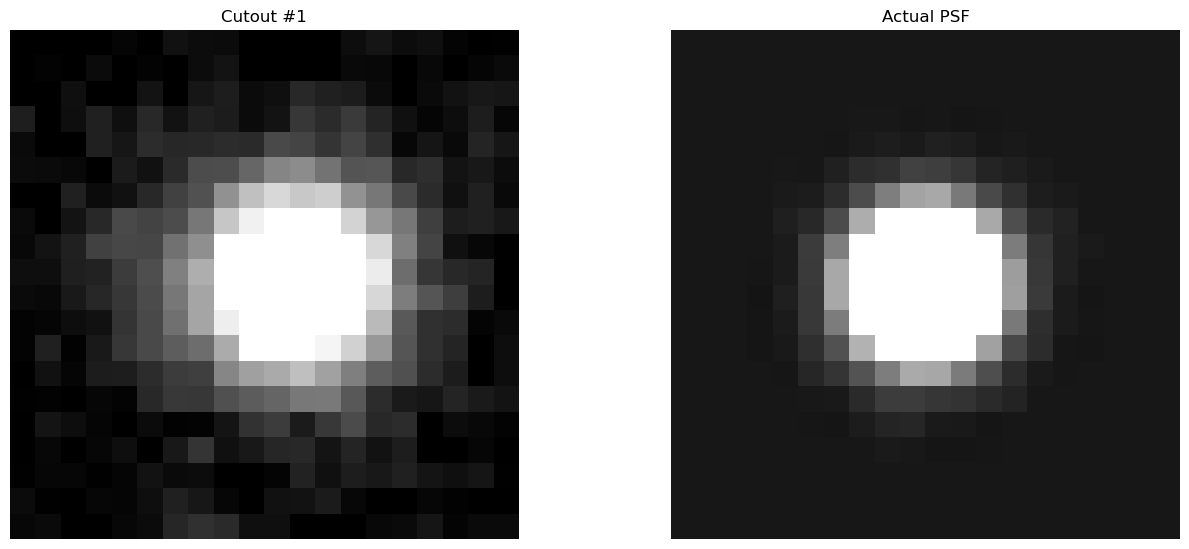

  1%|▏         | 257/20000 [00:00<00:15, 1305.99it/s, Round = 2,step_size = 5.0e-04 loss: 7.232e+04]


cutout: #1 n: 0.80868, ellip: 0.04775, r_eff: 3.2089598


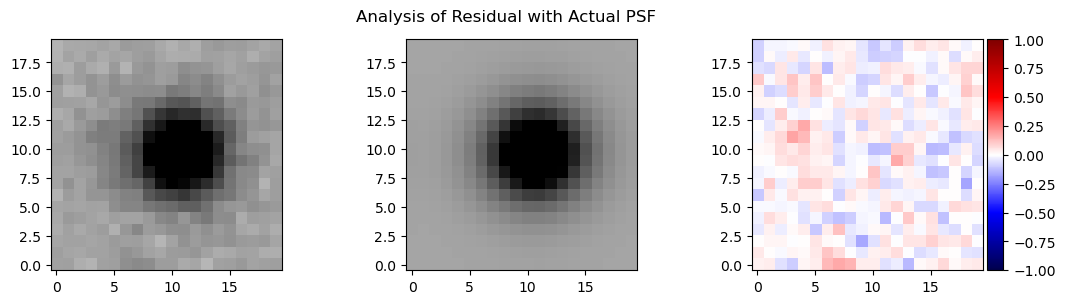

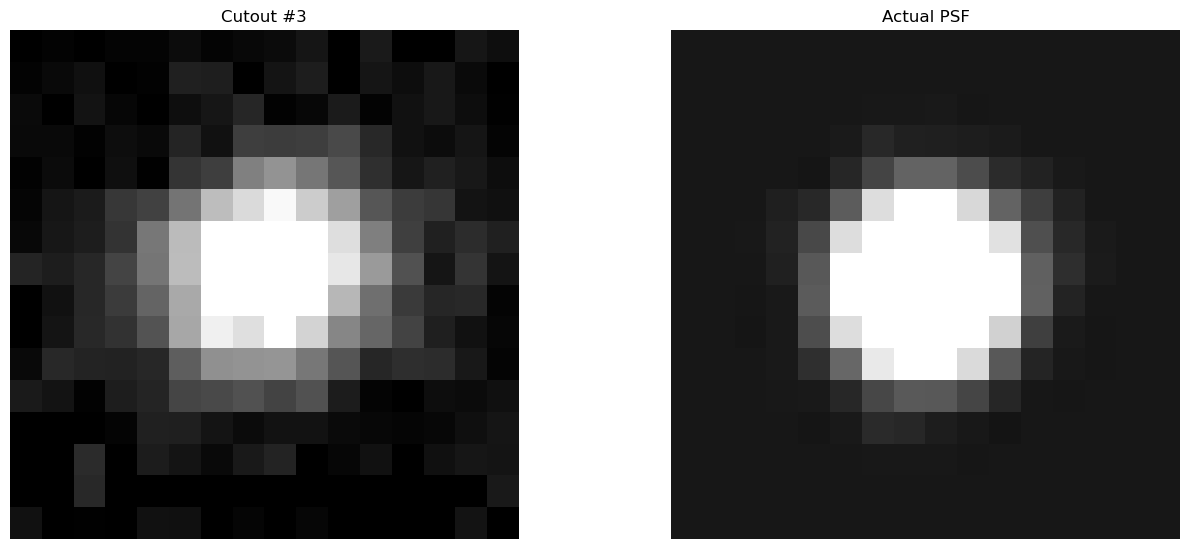

  1%|▏         | 275/20000 [00:00<00:11, 1670.05it/s, Round = 2,step_size = 5.0e-04 loss: 4.599e+04]


cutout: #3 n: 0.65009, ellip: 0.16619, r_eff: 2.63462


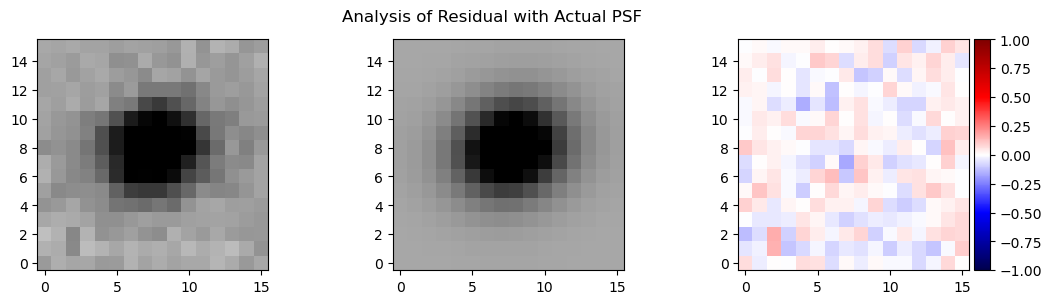

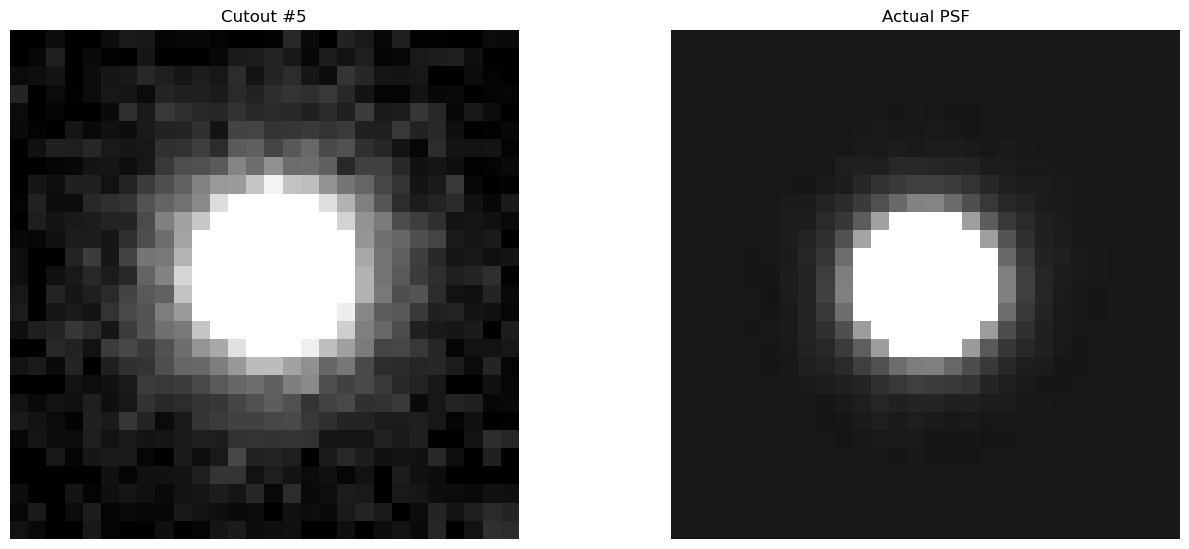

  1%|▏         | 261/20000 [00:00<00:18, 1072.75it/s, Round = 2,step_size = 5.0e-04 loss: 1.605e+05]


cutout: #5 n: 1.29967, ellip: 0.02021, r_eff: 3.84233


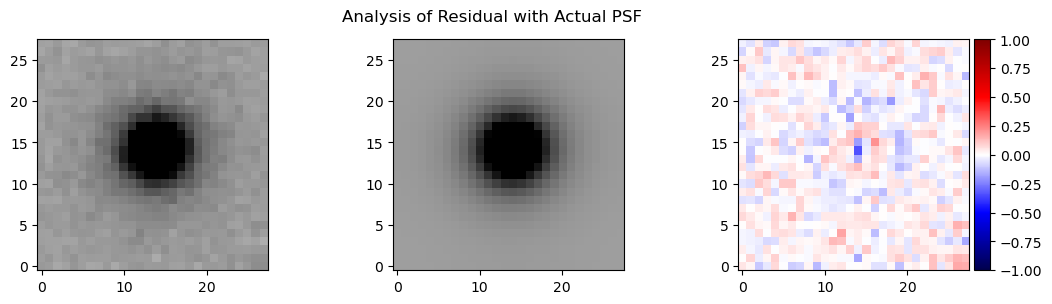

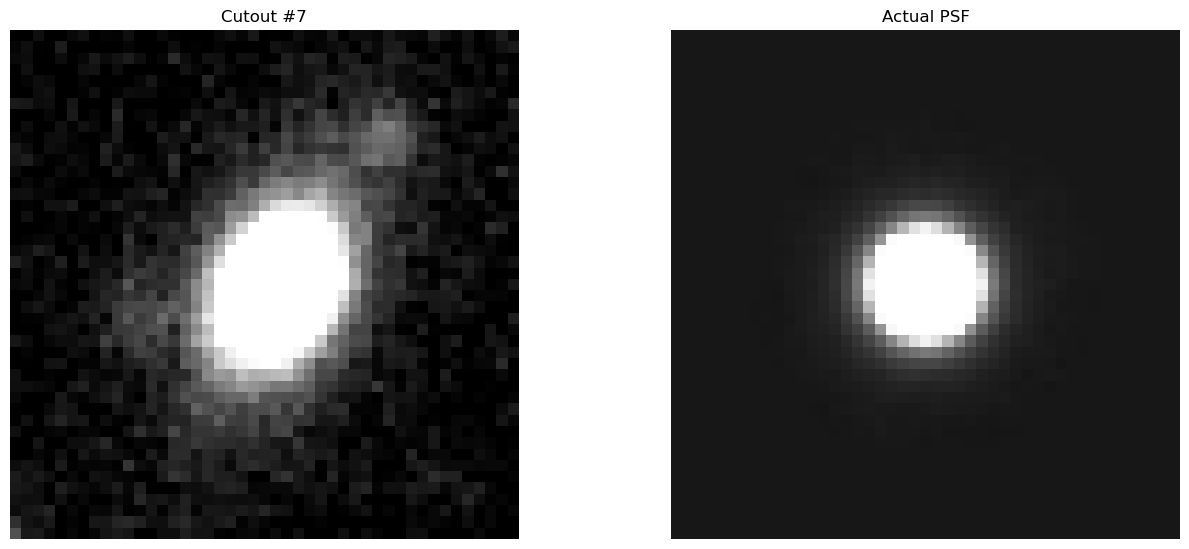

  2%|▏         | 368/20000 [00:00<00:23, 844.10it/s, Round = 2,step_size = 5.0e-04 loss: 5.493e+05]


cutout: #7 n: 2.4828498, ellip: 0.36964, r_eff: 4.46414


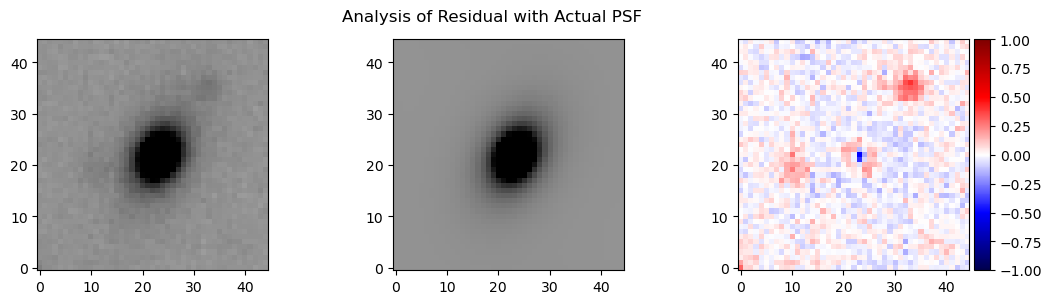

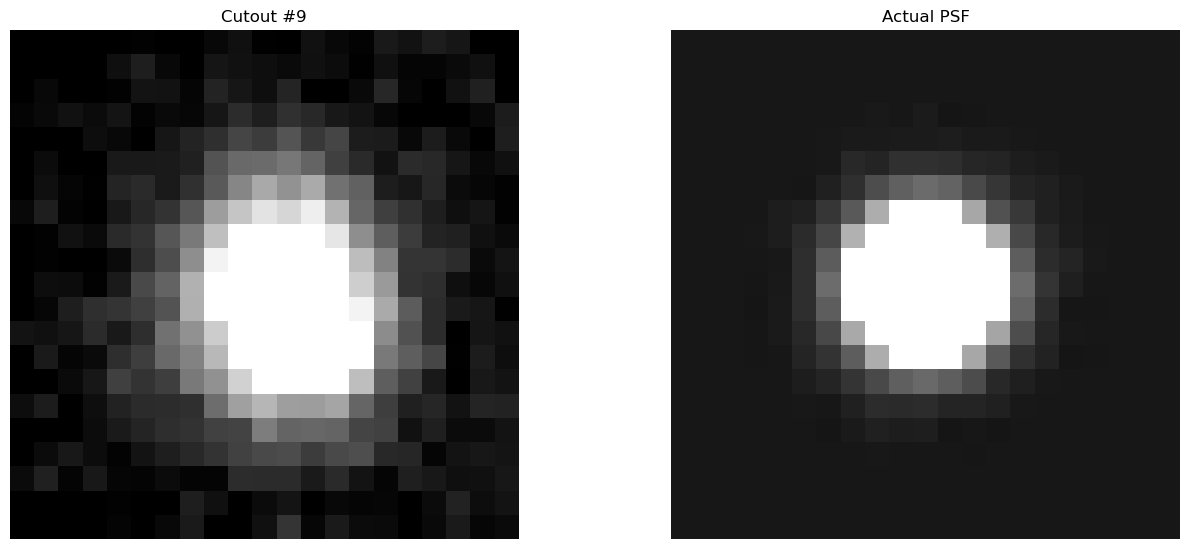

  1%|▏         | 262/20000 [00:00<00:14, 1336.46it/s, Round = 2,step_size = 5.0e-04 loss: 9.306e+04]


cutout: #9 n: 0.65002996, ellip: 0.18439, r_eff: 3.4677498


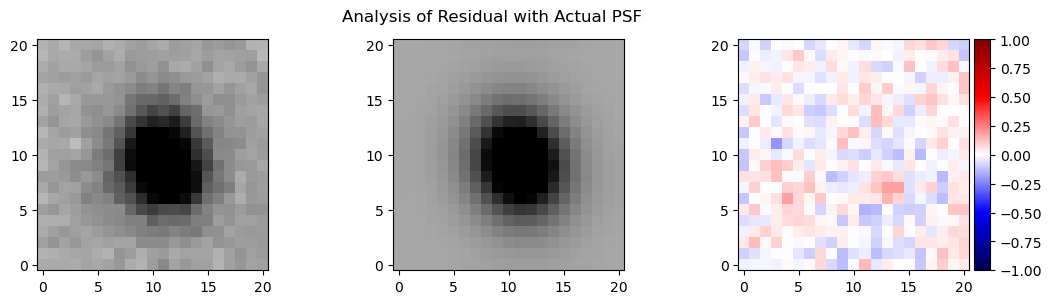

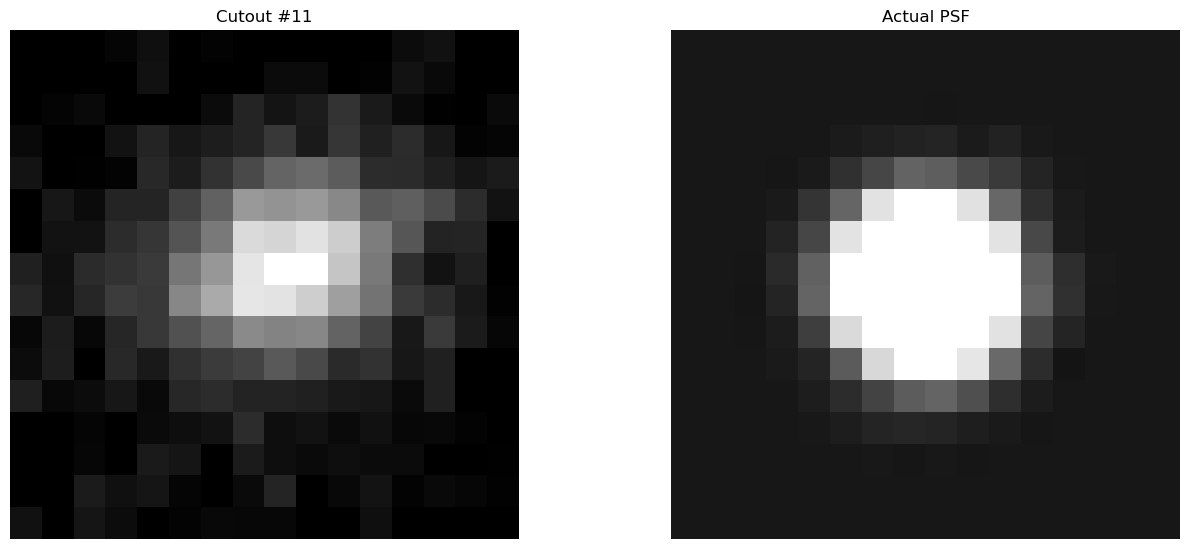

  1%|▏         | 252/20000 [00:00<00:12, 1591.53it/s, Round = 2,step_size = 5.0e-04 loss: 3.917e+04]


cutout: #11 n: 0.67042, ellip: 0.26751998, r_eff: 3.0613198


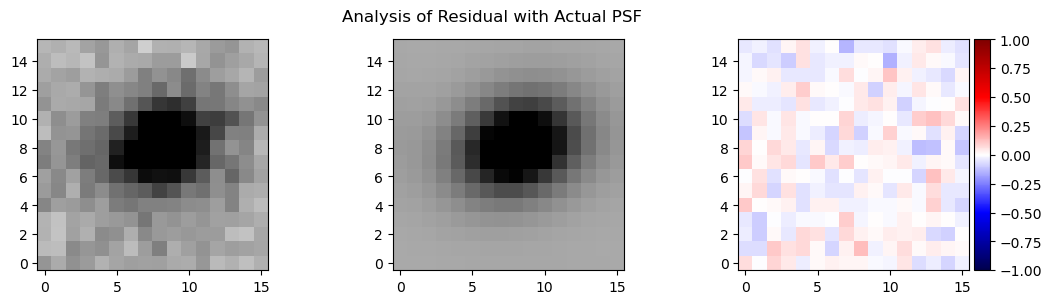

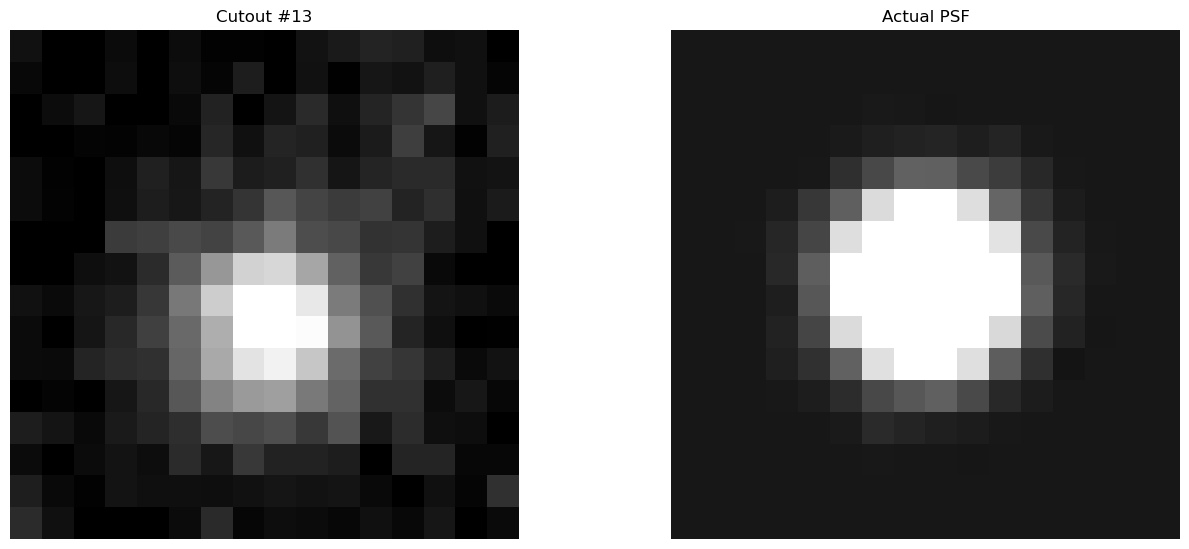

  1%|▏         | 277/20000 [00:00<00:13, 1500.93it/s, Round = 2,step_size = 5.0e-04 loss: 5.570e+04]


cutout: #13 n: 0.93131, ellip: 0.072629996, r_eff: 3.08858


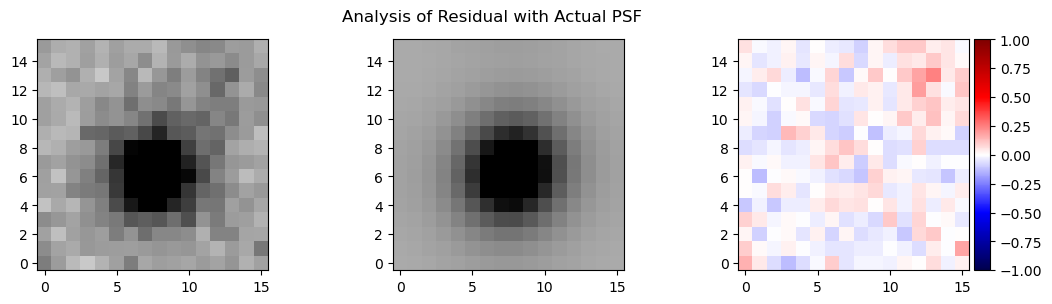

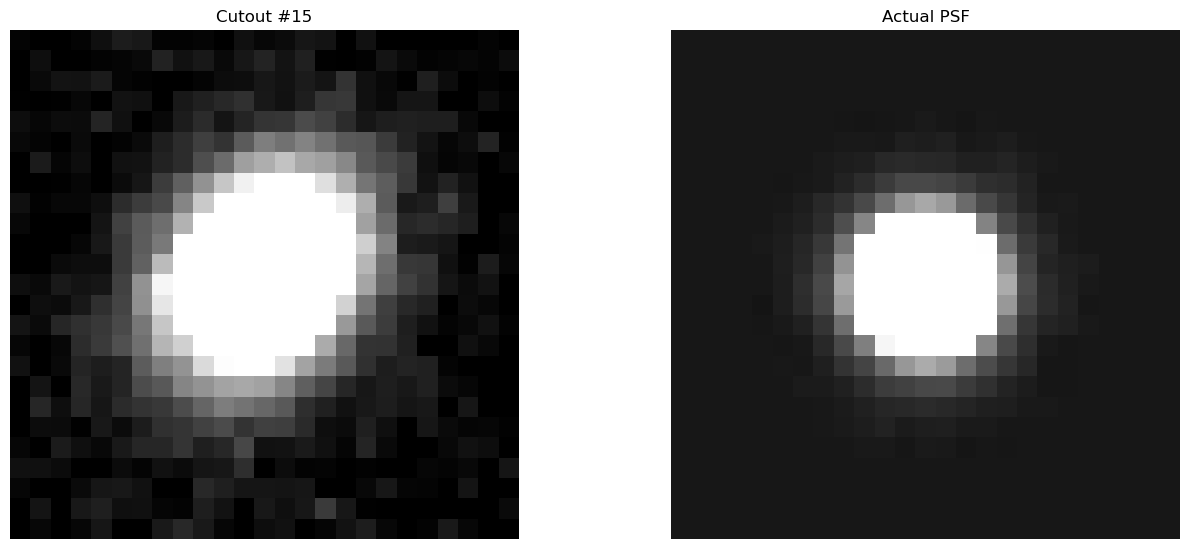

  4%|▍         | 845/20000 [00:00<00:15, 1199.89it/s, Round = 2,step_size = 5.0e-04 loss: 1.128e+05]


cutout: #15 n: 0.86070997, ellip: 0.22126, r_eff: 3.6406798


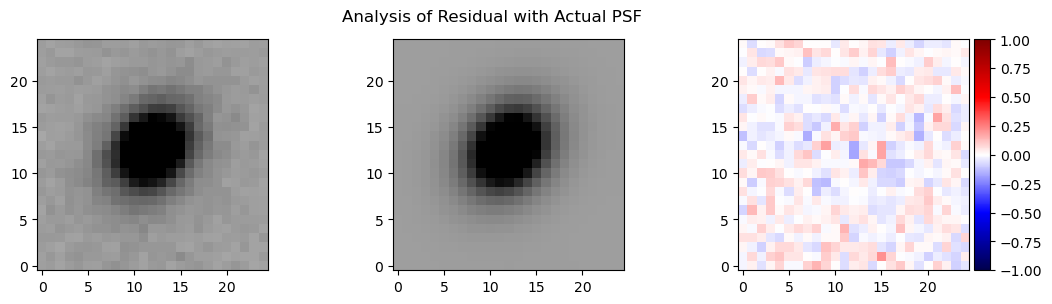

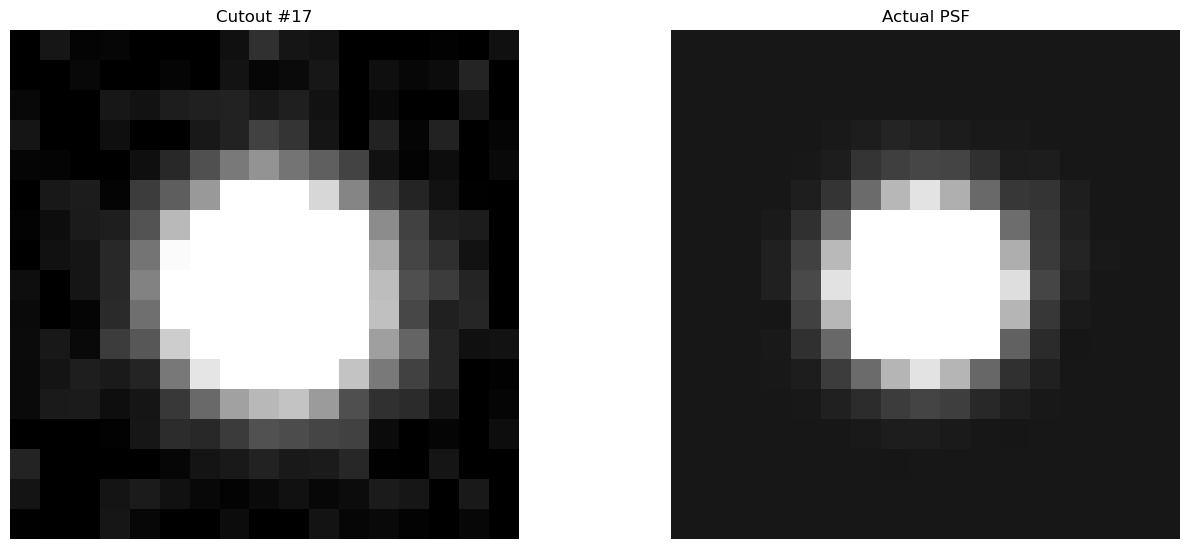

  3%|▎         | 596/20000 [00:00<00:11, 1671.86it/s, Round = 2,step_size = 5.0e-04 loss: 5.776e+04]


cutout: #17 n: 0.65001, ellip: 0.01263, r_eff: 1.82906


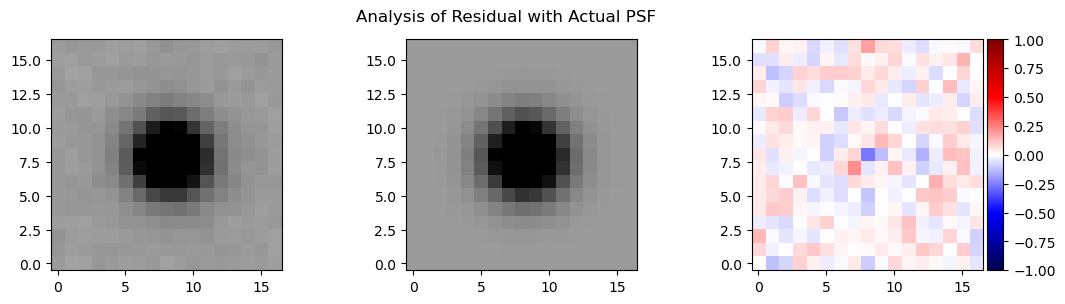

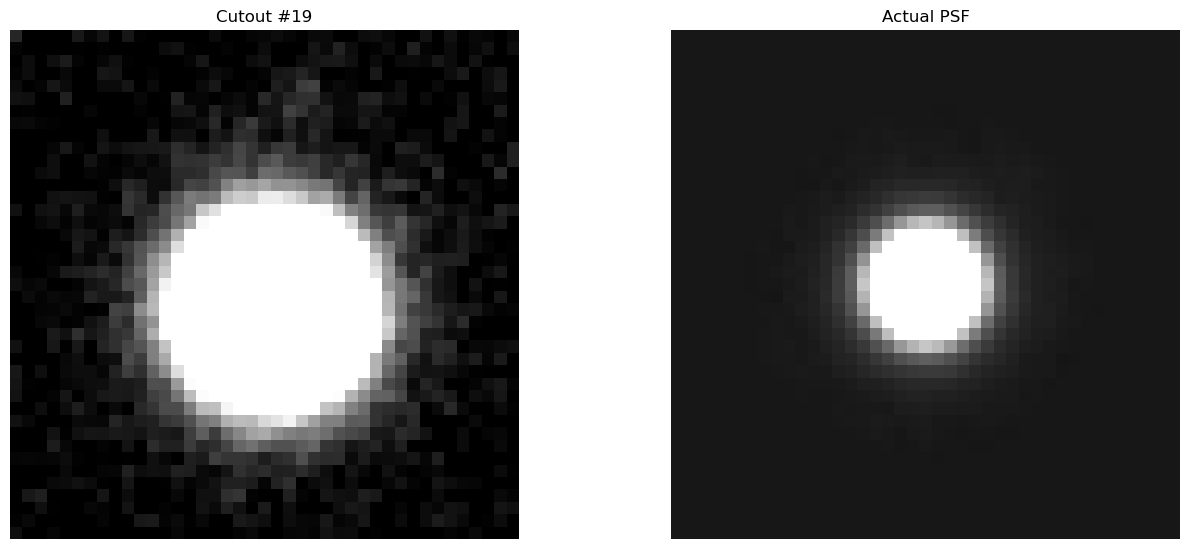

  1%|▏         | 251/20000 [00:00<00:20, 975.93it/s, Round = 2,step_size = 5.0e-04 loss: 1.797e+06]


cutout: #19 n: 1.49699, ellip: 0.0051599997, r_eff: 1.06924


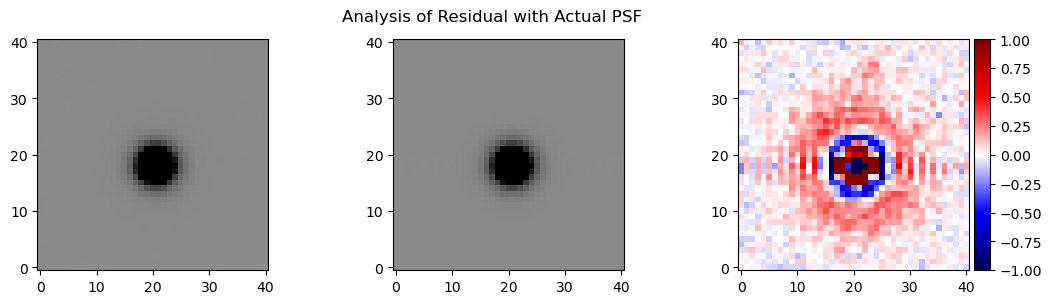

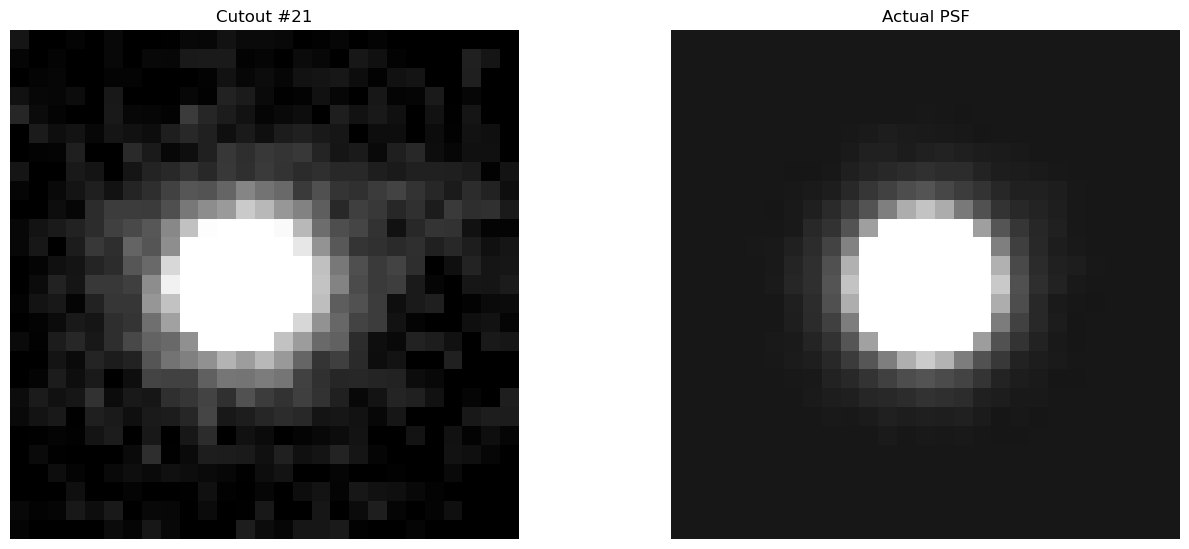

  1%|▏         | 299/20000 [00:00<00:17, 1153.78it/s, Round = 2,step_size = 5.0e-04 loss: 1.416e+05]


cutout: #21 n: 1.2324699, ellip: 0.07792, r_eff: 3.40725


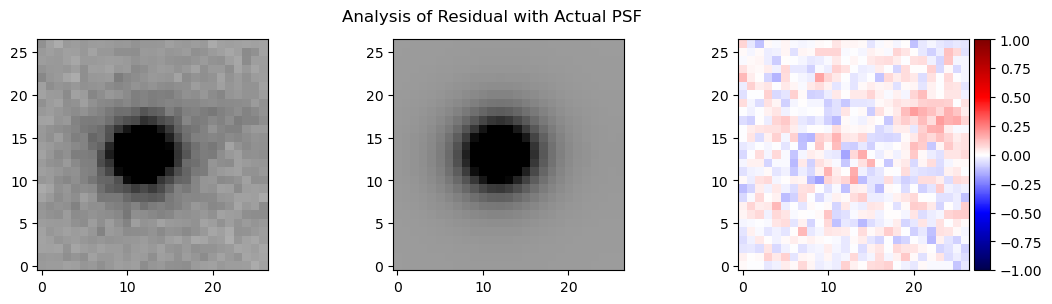

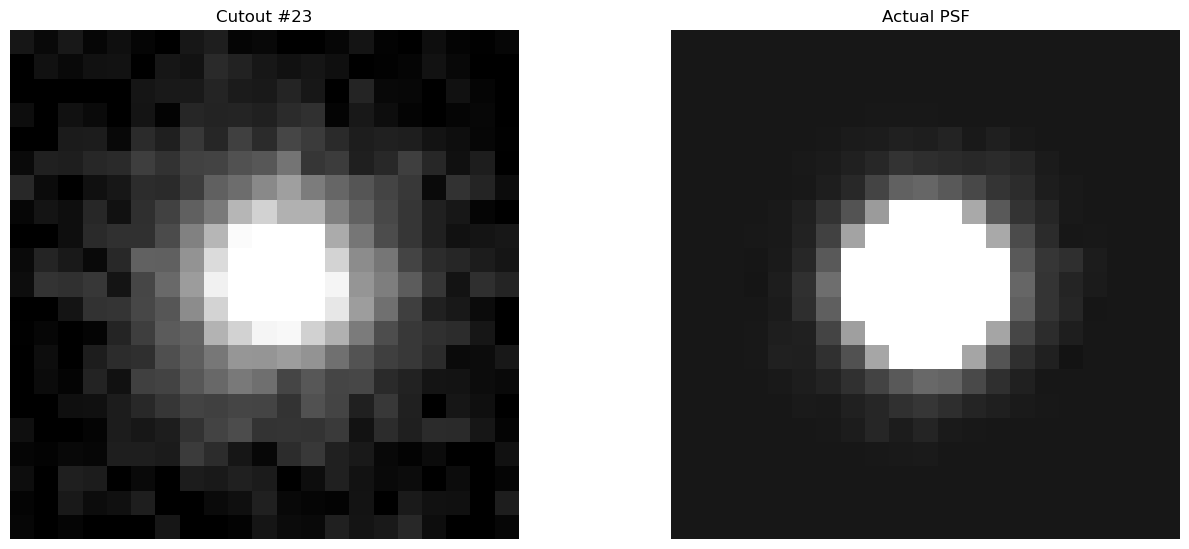

  1%|▏         | 251/20000 [00:00<00:14, 1377.15it/s, Round = 2,step_size = 5.0e-04 loss: 6.786e+04]


cutout: #23 n: 0.92464995, ellip: 0.027199998, r_eff: 3.94941


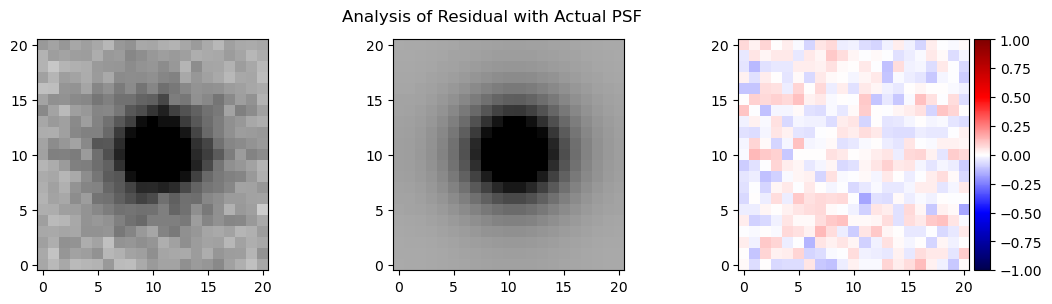

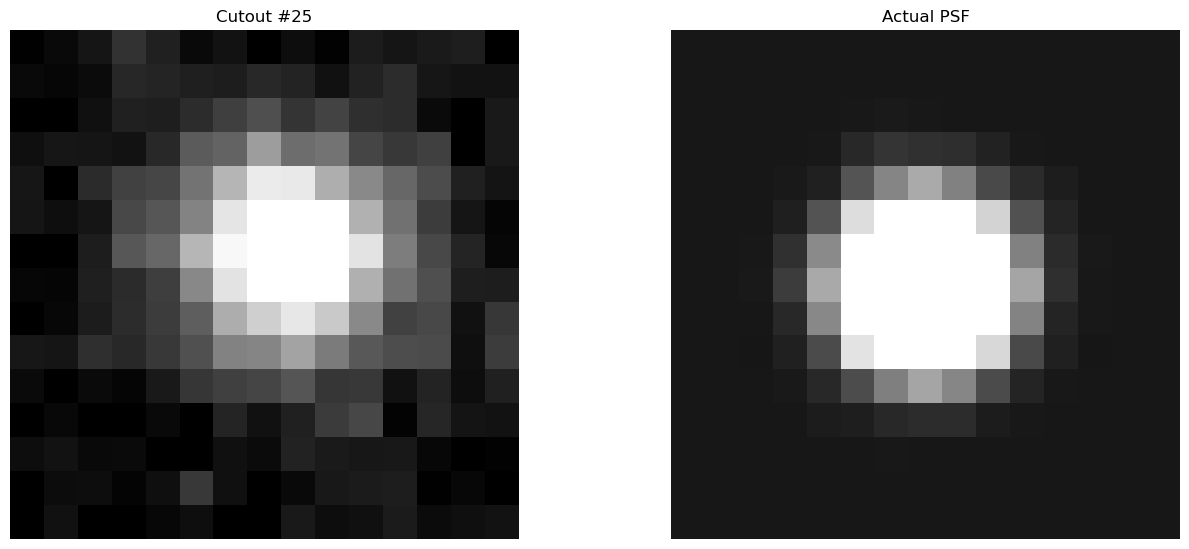

  3%|▎         | 582/20000 [00:00<00:09, 2021.05it/s, Round = 2,step_size = 5.0e-04 loss: 3.800e+04]


cutout: #25 n: 0.68860996, ellip: 0.076979995, r_eff: 2.79073


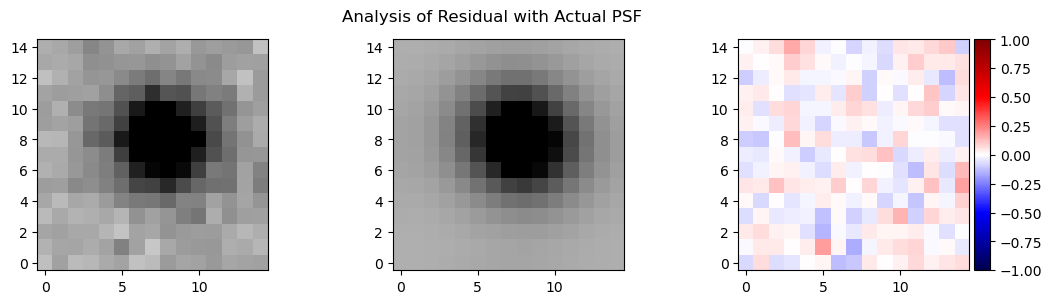

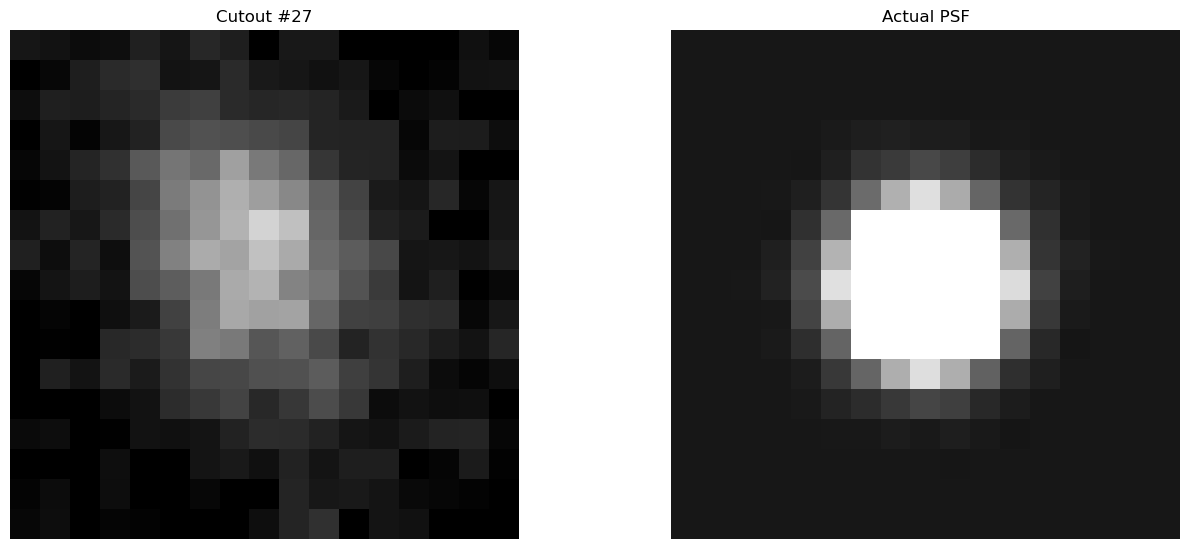

  1%|▏         | 261/20000 [00:00<00:14, 1393.93it/s, Round = 2,step_size = 5.0e-04 loss: 4.977e+04]


cutout: #27 n: 0.65001, ellip: 0.25917998, r_eff: 3.8761299


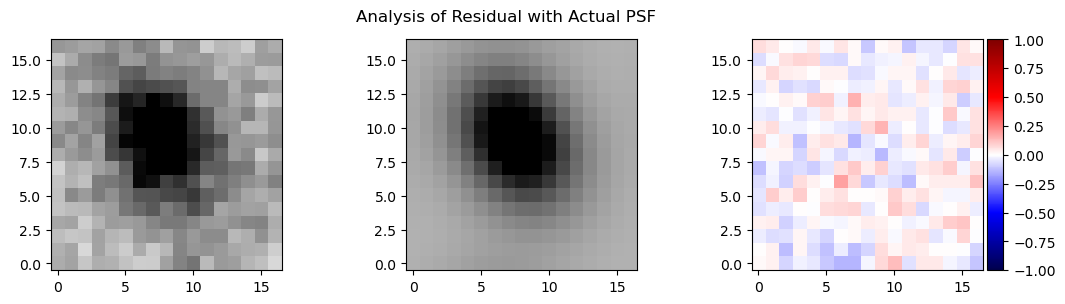

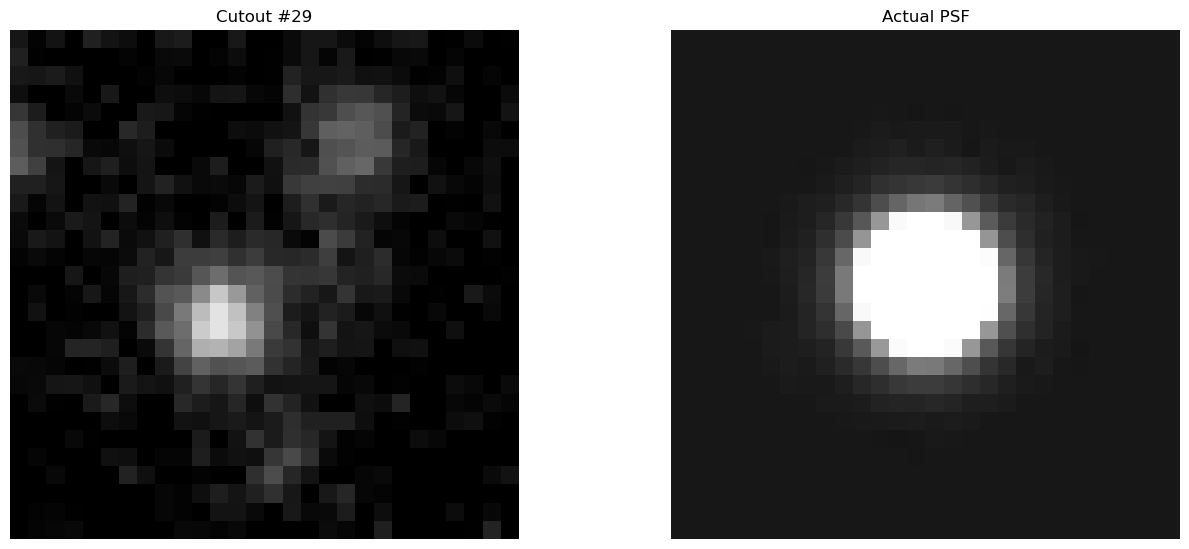

  1%|▏         | 252/20000 [00:00<00:19, 1002.35it/s, Round = 2,step_size = 5.0e-04 loss: 2.925e+05]


cutout: #29 n: 2.8185399, ellip: 0.16229999, r_eff: 6.64786


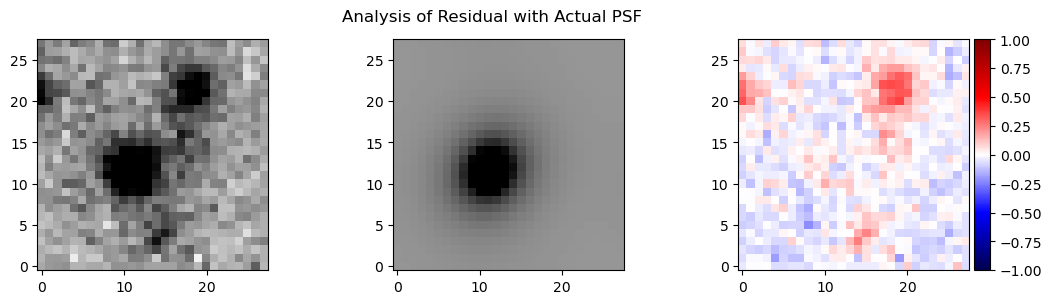

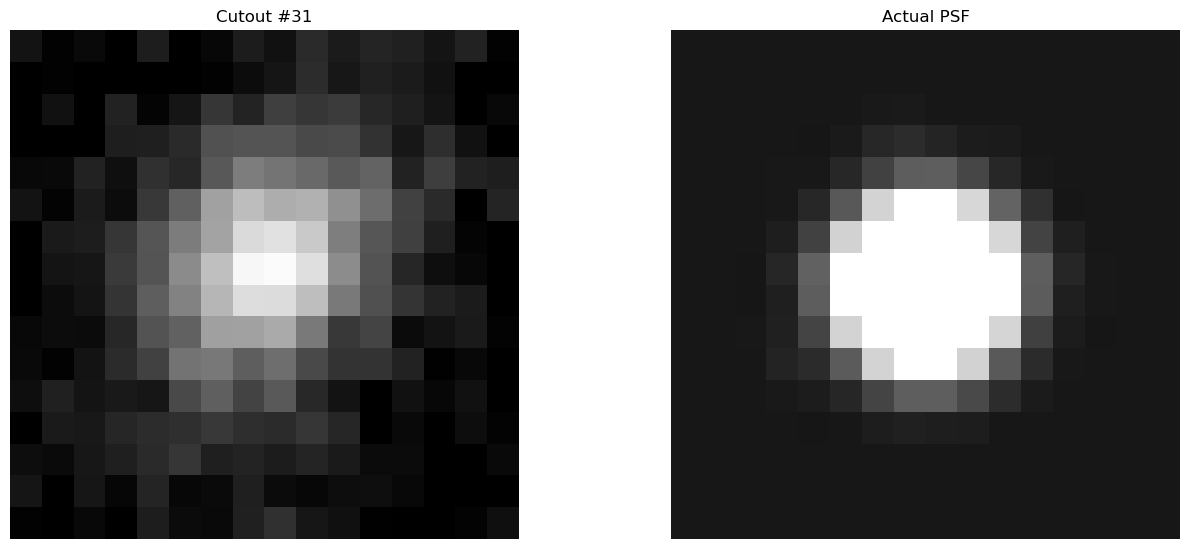

  1%|▏         | 253/20000 [00:00<00:13, 1498.52it/s, Round = 2,step_size = 5.0e-04 loss: 3.808e+04]


cutout: #31 n: 0.65007997, ellip: 0.26547998, r_eff: 3.50666


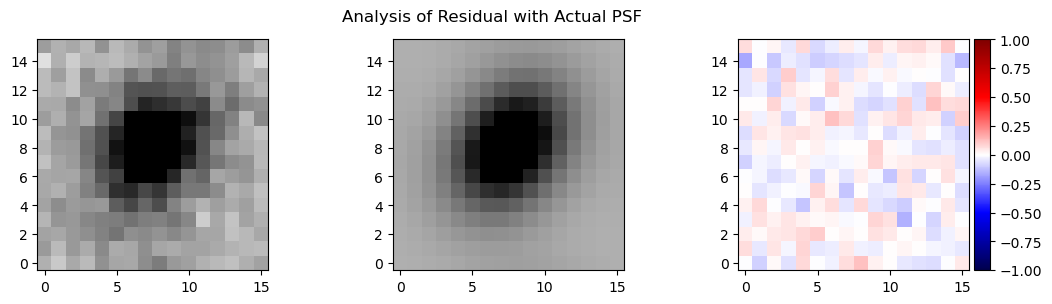

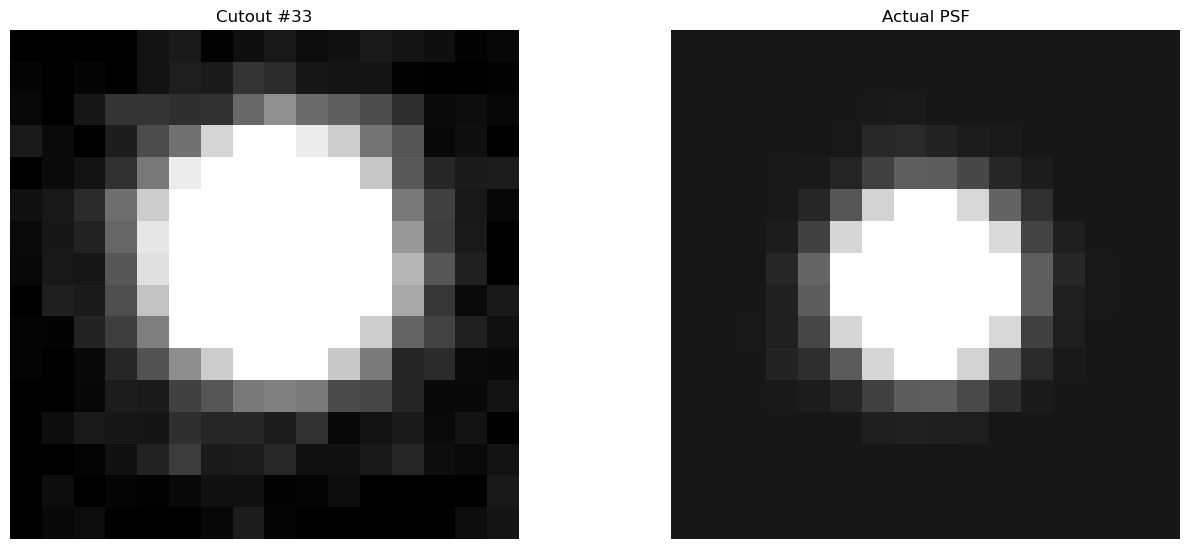

  1%|▏         | 290/20000 [00:00<00:13, 1514.41it/s, Round = 2,step_size = 5.0e-04 loss: 6.000e+04]


cutout: #33 n: 0.65002996, ellip: 0.00405, r_eff: 1.82747


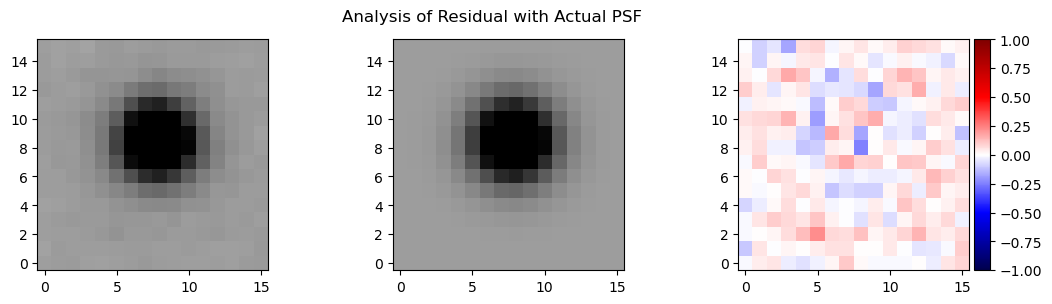

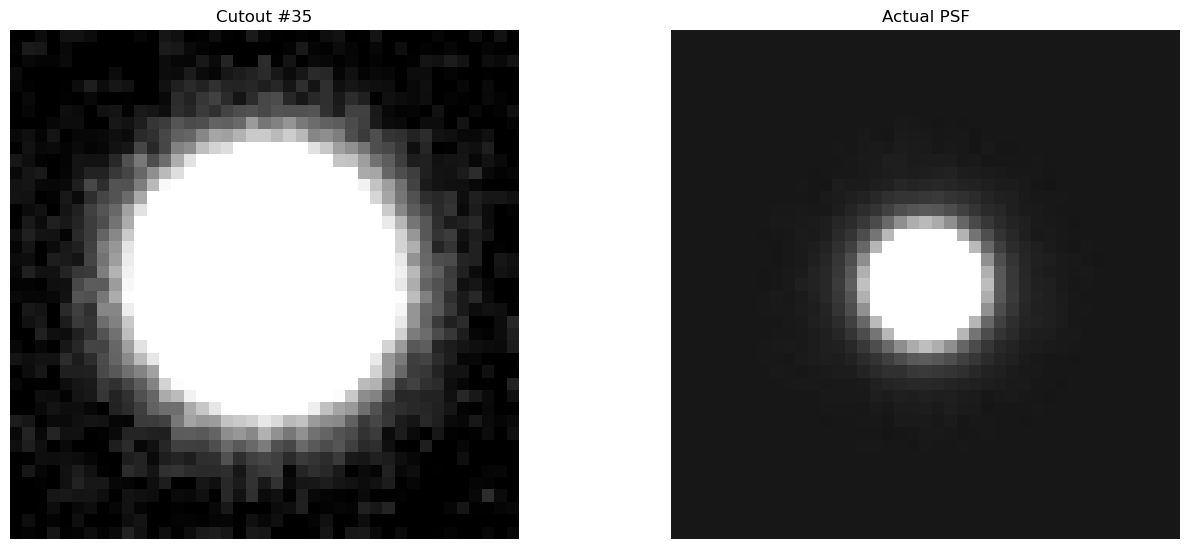

  1%|▏         | 264/20000 [00:00<00:22, 858.15it/s, Round = 2,step_size = 5.0e-04 loss: 7.197e+06]


cutout: #35 n: 1.71802, ellip: 0.0044, r_eff: 1.07181


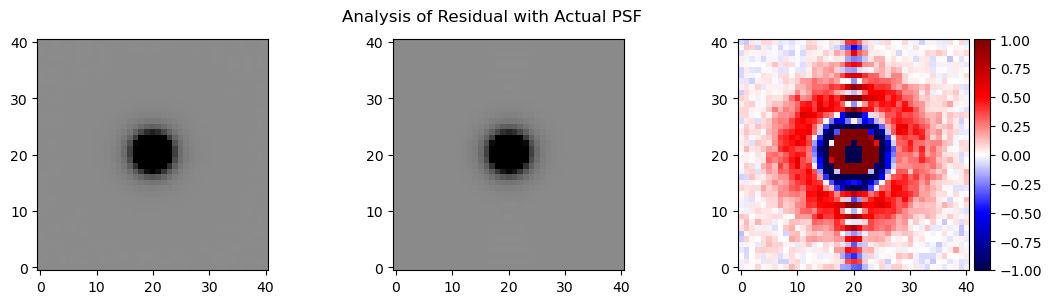

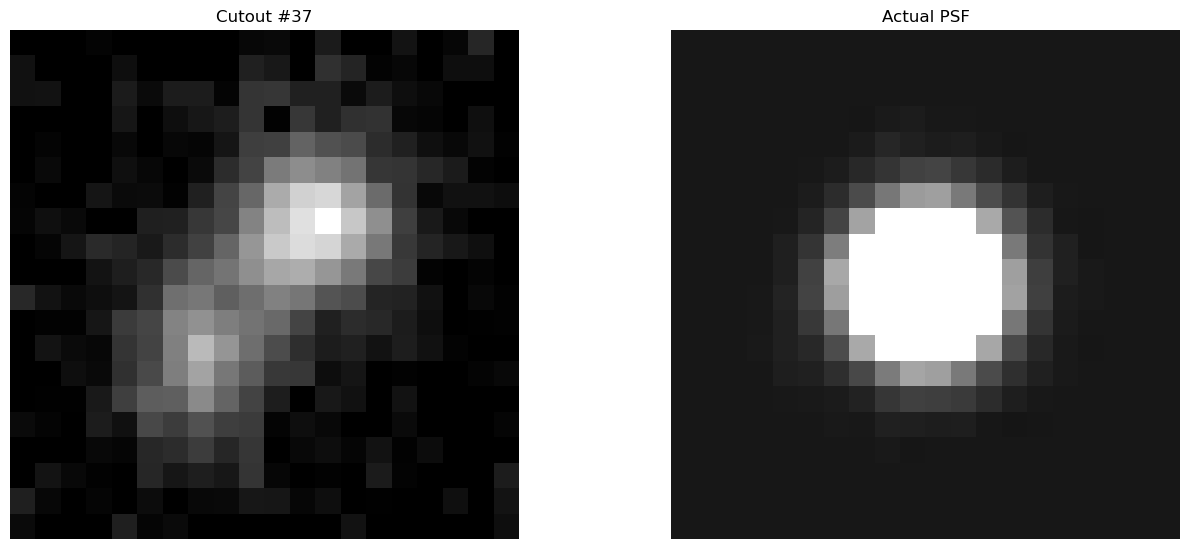

  1%|▏         | 257/20000 [00:00<00:16, 1229.52it/s, Round = 2,step_size = 5.0e-04 loss: 1.447e+05]


cutout: #37 n: 0.65001, ellip: 0.54148, r_eff: 5.07502


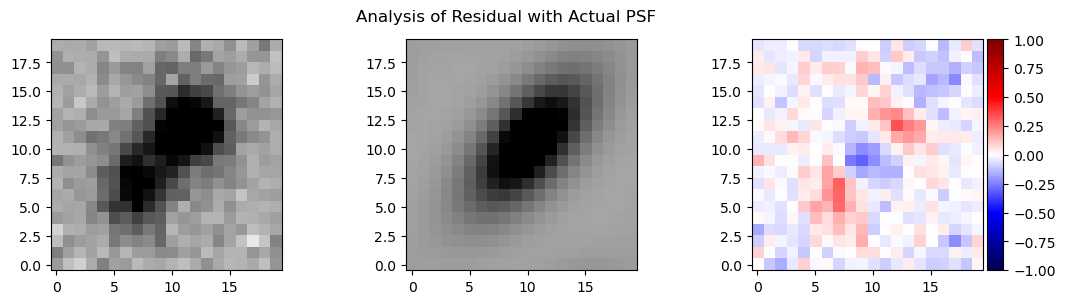

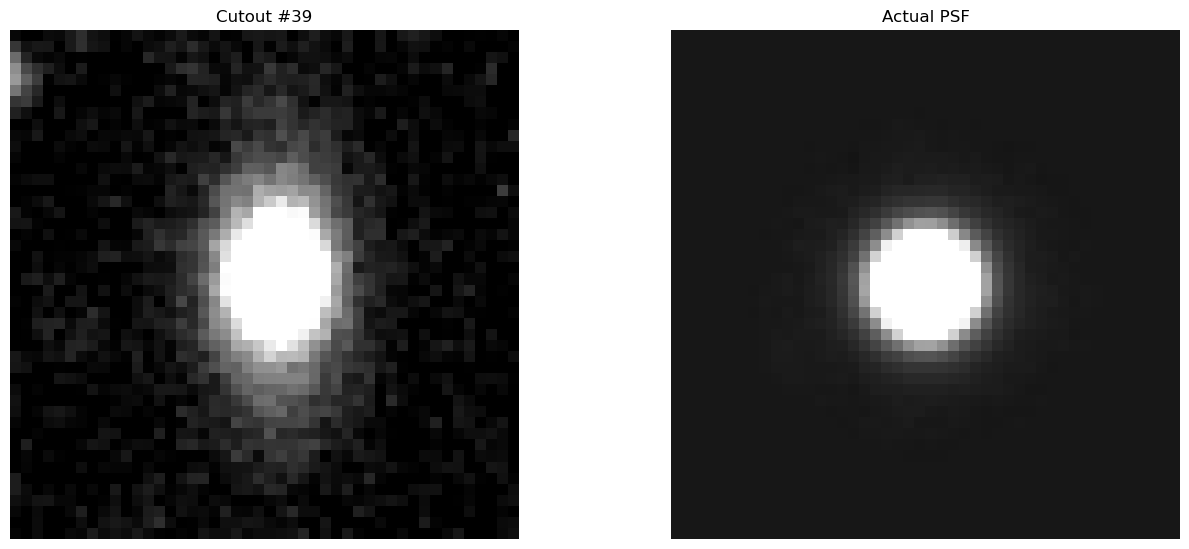

  1%|▏         | 251/20000 [00:00<00:24, 809.16it/s, Round = 2,step_size = 5.0e-04 loss: 5.104e+05]


cutout: #39 n: 2.0216498, ellip: 0.37333, r_eff: 5.64748


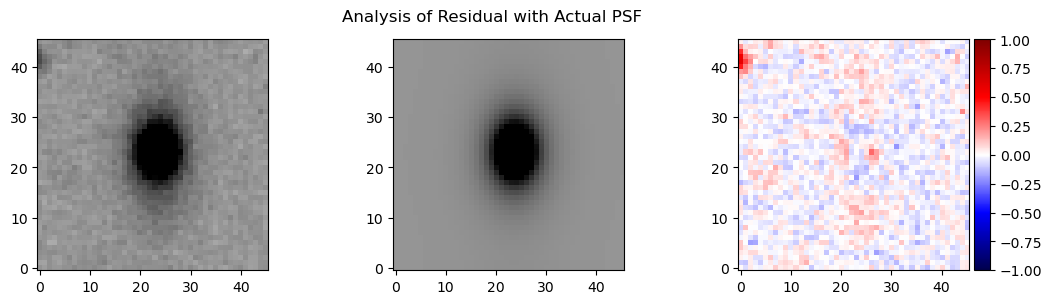

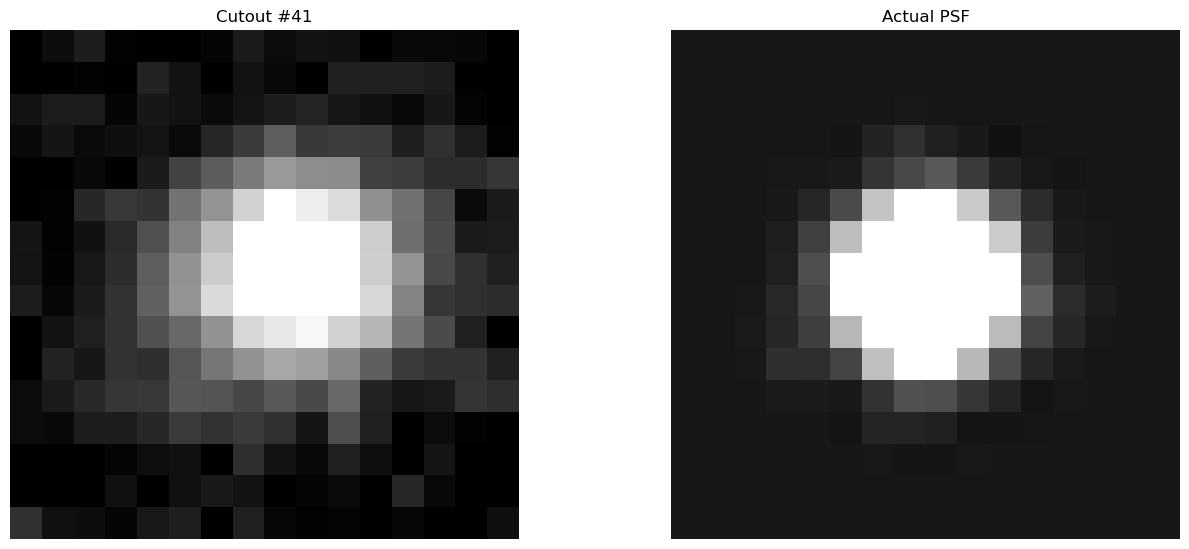

  2%|▏         | 301/20000 [00:00<00:13, 1495.97it/s, Round = 2,step_size = 5.0e-04 loss: 4.512e+04]


cutout: #41 n: 0.65014, ellip: 0.12798, r_eff: 2.92587


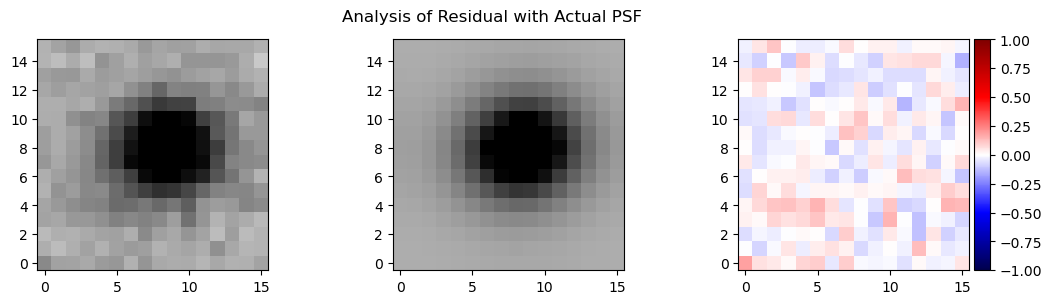

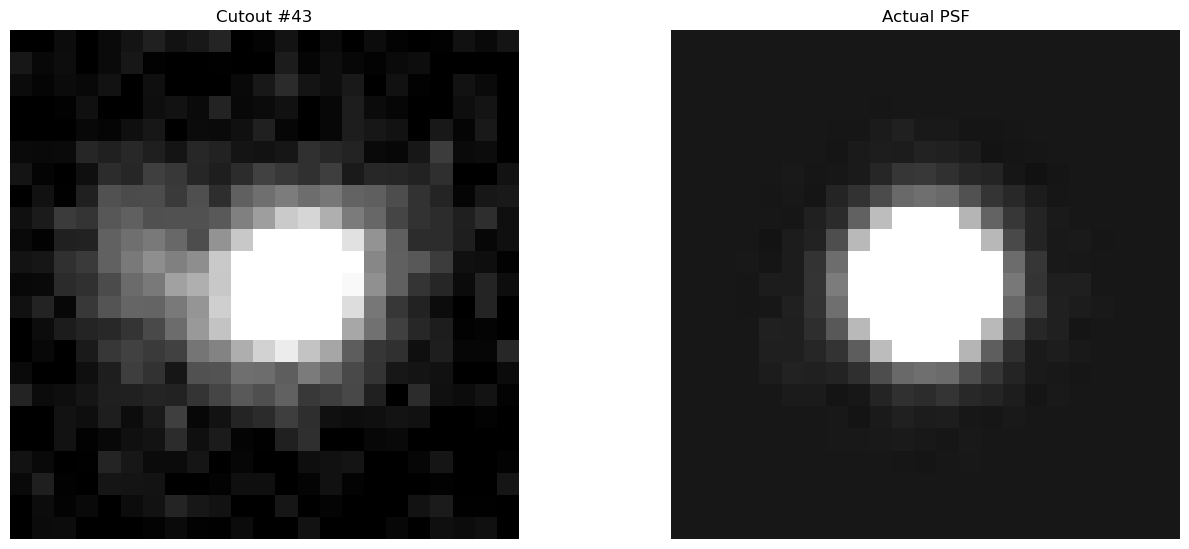

  1%|▏         | 251/20000 [00:00<00:17, 1130.28it/s, Round = 2,step_size = 5.0e-04 loss: 1.768e+05]


cutout: #43 n: 1.10939, ellip: 0.23255, r_eff: 4.05163


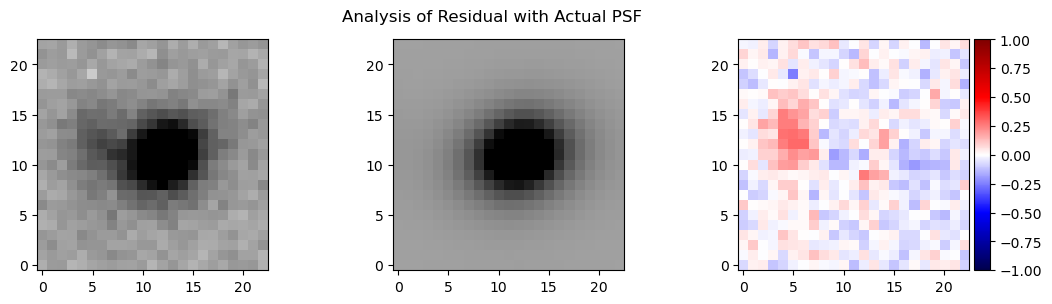

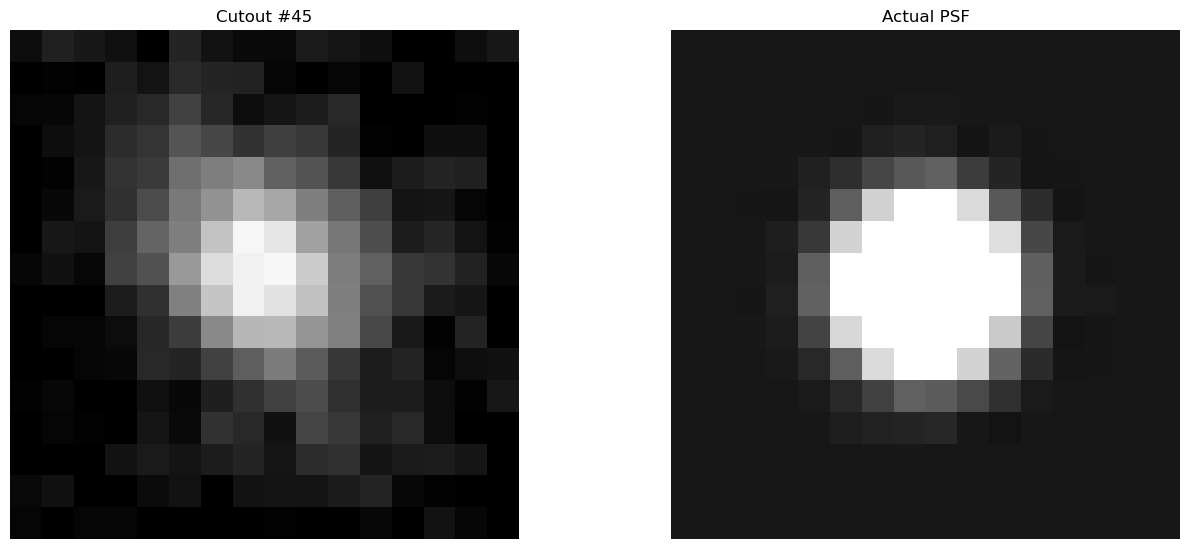

  1%|▏         | 251/20000 [00:00<00:12, 1581.02it/s, Round = 2,step_size = 5.0e-04 loss: 4.843e+04]


cutout: #45 n: 0.65001, ellip: 0.25509998, r_eff: 3.17589


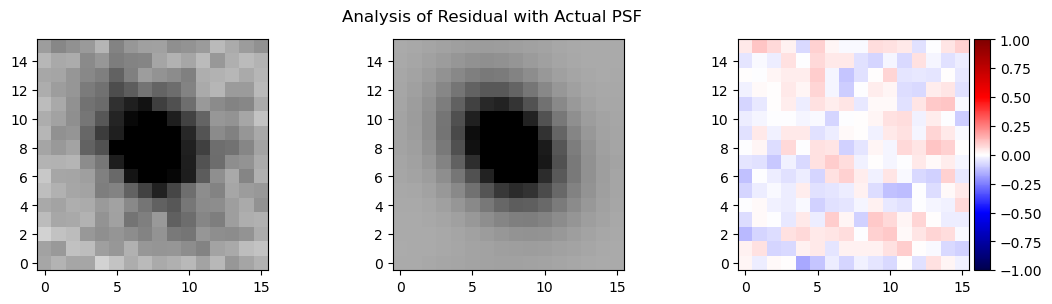

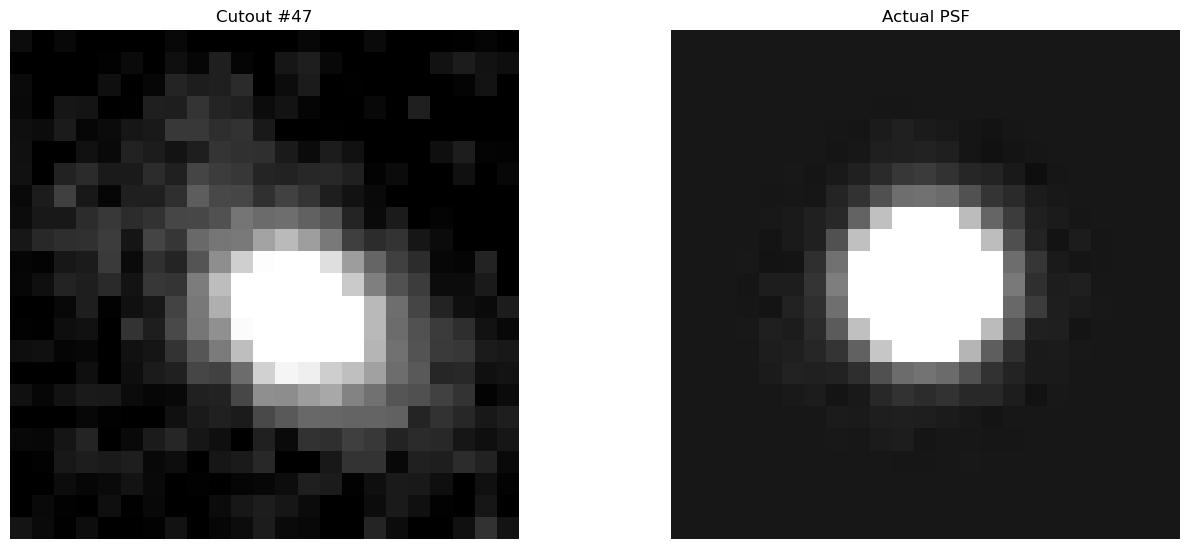

  2%|▏         | 314/20000 [00:00<00:16, 1185.15it/s, Round = 2,step_size = 5.0e-04 loss: 1.116e+05]


cutout: #47 n: 0.95063996, ellip: 0.32852, r_eff: 4.32956


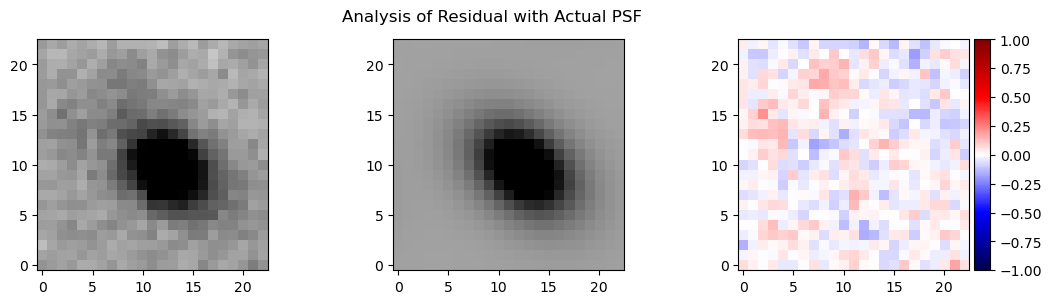

In [331]:
# Fitting a Sersic Profile
from pysersic import FitSingle
from pysersic.loss import student_t_loss
from pysersic import results
from pysersic.priors import autoprior
from pysersic.priors import SourceProperties
from pysersic import check_input_data
from pysersic import FitSingle
from pysersic.loss import gaussian_loss
from pysersic.results import plot_residual
# Testing on One Cutout --> Estimating Values Before

for i in range(1,len(cutouts)-5,2):
    im,mask,sig,psf,actual_psf = cutouts[i] # image, mask, variance
    if (im.shape[0] != im.shape[1]):
        pass
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))
        prior = autoprior(image = im.data, profile_type = 'sersic', mask=mask, sky_type = 'none')
    
        # print(im.data.shape)
        # print(mask.shape)
        # print(sig.data.shape)
        # print(actual_psf.shape)
        axes[0].imshow(im.data, cmap='gray', origin="lower",vmin=-0.0001,vmax=1)
        axes[0].set_title(f'Cutout #{i}')
        axes[0].axis('off')
    
        # axes[1].imshow(psf, cmap='gray',origin="lower")
        # axes[1].set_title('Generated Gauss. PSF')
        # axes[1].axis('off')
    
        axes[1].imshow(actual_psf, cmap='gray',origin="lower")
        axes[1].set_title('Actual PSF')
        axes[1].axis('off')
        plt.imshow(actual_psf, cmap='gray', origin="lower",vmin=-0.0001,vmax=0.001)#,interpolation='none')
    
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.show()
        
        # # Sersic Fitting using Gaussian PSF
        # props = SourceProperties(im.data,mask=mask) # Optional mask
        # prior = props.generate_prior('sersic',sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background
        # check_input_data(im.data, sig.data, psf, mask)
        # fitter = FitSingle(data=im.data,rms=sig.data, psf=psf, prior=prior, mask=mask, loss_func=gaussian_loss) 
        # map_params = fitter.find_MAP(rkey = PRNGKey(1000));
        # fig, ax = plot_residual(im.data,map_params['model'],mask=mask,vmin=-1,vmax=1);
        # fig.suptitle("Analysis of Residual using Generated PSF")
        
        # Sersic Fitting using Actual PSF
        props2 = SourceProperties(im.data,mask=mask) # Optional mask
        prior2 = props2.generate_prior('sersic',sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background
        check_input_data(im.data, sig.data, actual_psf, mask)
        fitter2 = FitSingle(data=im.data,rms=sig.data, psf=actual_psf, prior=prior2, mask=mask, loss_func=gaussian_loss) 
        map_params2 = fitter2.find_MAP(rkey = PRNGKey(1000));
        fig2, ax2 = plot_residual(im.data,map_params2['model'],mask=mask,vmin=-1,vmax=1);
        fig2.suptitle("Analysis of Residual with Actual PSF")
        print('cutout: #' + str(i) + ' n: '+str(map_params2['n'])+', ellip: '+str(map_params2['ellip'])+', r_eff: '+str(map_params2['r_eff']))
        # for i in map_params2.keys():
        #     print(i + ": " + str(map_params2[i]))
    
# fitter = FitSingle(data=im.data,rms=sig.data,mask=mask,psf=normalized_psf,prior=prior,loss_func=student_t_loss)